# Credit Card Routing for Online Purchase via Predictive Modelling

In [1]:
#Import warnings
import warnings
warnings.filterwarnings('ignore')

#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve  
from sklearn.model_selection import learning_curve 
import shap

#To display upto 100 rows and columns
pd.set_option('display.max_rows', 100,'display.max_columns', 100)

## Data Understanding

In [2]:
#Read the PSP_Jan_Feb_2019 dataset as data
data = pd.read_excel('PSP_Jan_Feb_2019.xlsx')
data.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [3]:
#Basic information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


In [4]:
#Statistical summary of numerical columns
data.describe()

,Unnamed: 0,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000,50410.000000
mean,25204.500000,202.395715,0.202896,0.238266
std,14552.257872,96.274730,0.402160,0.426027
min,0.000000,6.000000,0.000000,0.000000
25%,12602.250000,133.000000,0.000000,0.000000
50%,25204.500000,201.000000,0.000000,0.000000
75%,37806.750000,269.000000,0.000000,0.000000
max,50409.000000,630.000000,1.000000,1.000000


In [5]:
#Drop the 'Unnamed: 0' column from the dataset
data = data.drop('Unnamed: 0', axis=1)

## Data Exploration

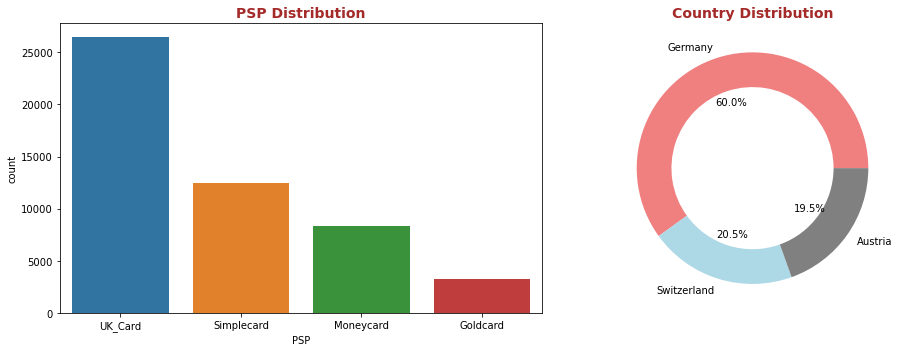

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#Distribution of Transactions by PSP
sns.countplot(x='PSP', data=data, ax=axs[0])
axs[0].set_title('PSP Distribution', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})

#Transaction Distribution Across Countries
country_counts = data['country'].value_counts()
axs[1].pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'gray'],
               wedgeprops=dict(width=0.3))
axs[1].set_title('Country Distribution', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})

plt.tight_layout()
plt.show()

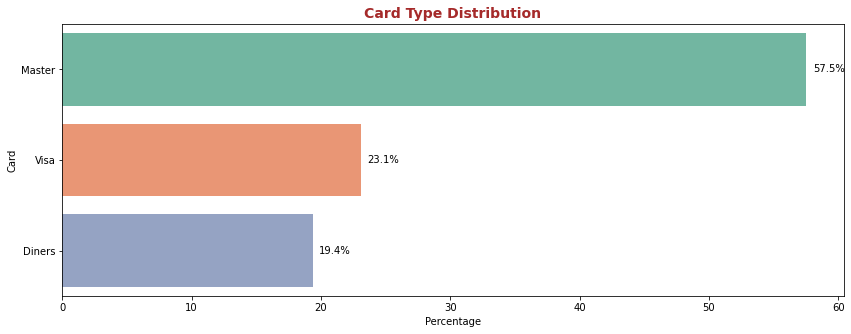

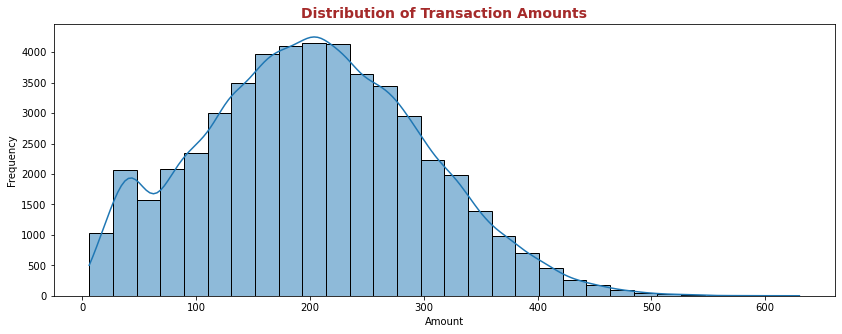

In [7]:
#Distribution of Transactions by Card Type
card_percent = data['card'].value_counts(normalize=True) * 100
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=card_percent.values, y=card_percent.index, palette='Set2')
for index, value in enumerate(card_percent):
    plt.text(value+0.5, index, f'{value:.1f}%', va='center')
plt.title('Card Type Distribution', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Percentage')
plt.ylabel('Card')
plt.show()

#Distribution of Transaction Amounts
plt.figure(figsize=(14, 5))
sns.histplot(data['amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Amounts', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

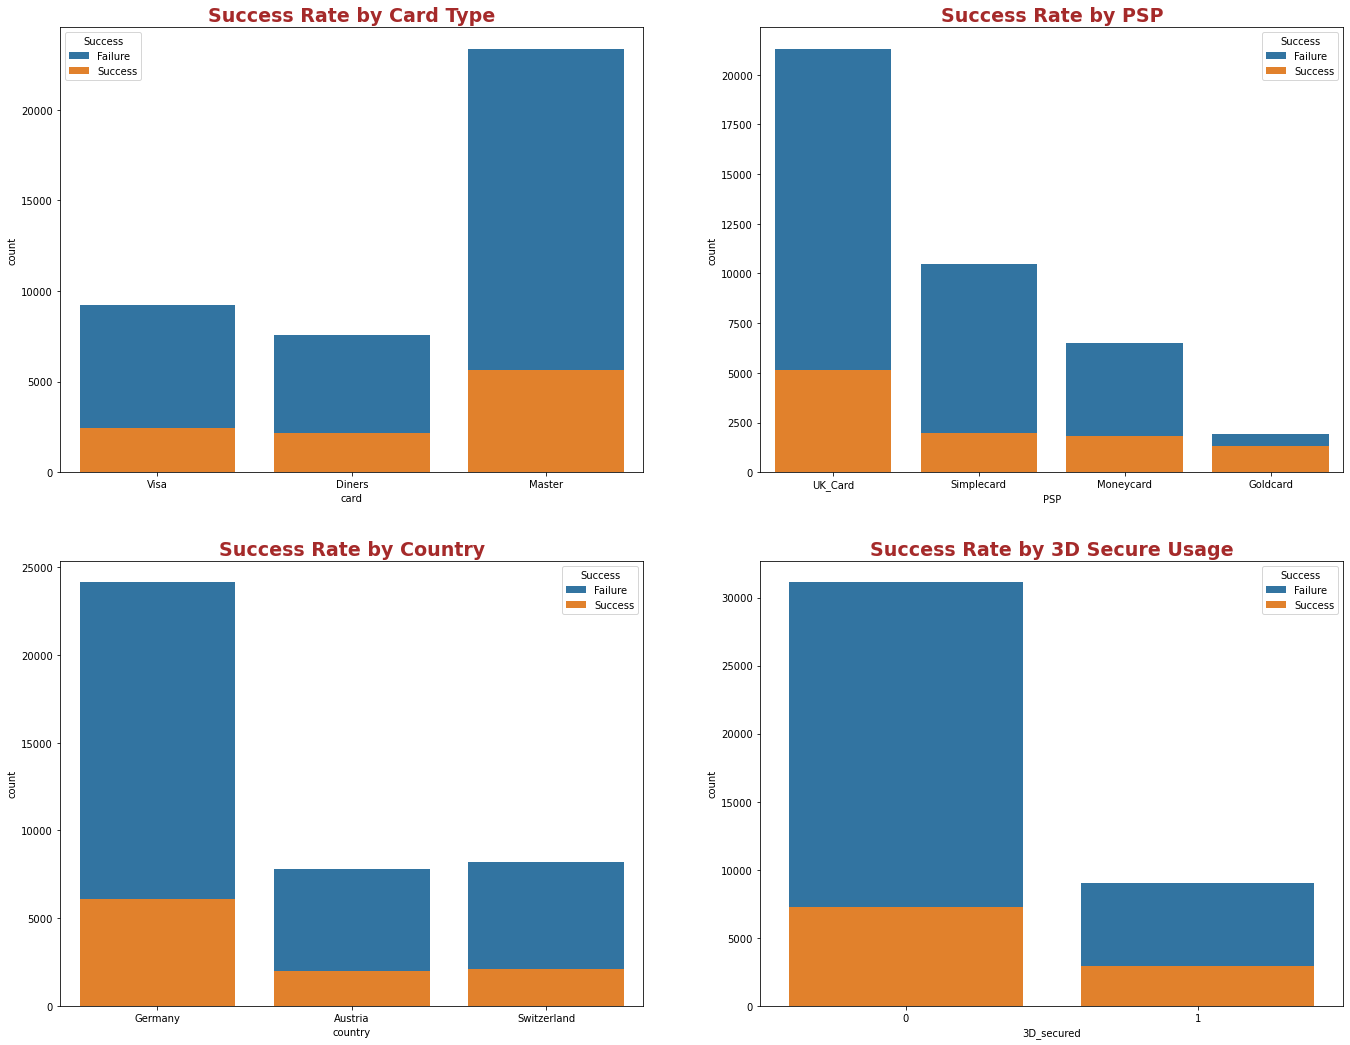

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(23, 18))

#Success Rates of Transactions by Card Type
sns.countplot(x='card', hue='success', data=data, ax=axs[0, 0], dodge=False)
axs[0, 0].set_title('Success Rate by Card Type', fontdict={'fontsize': 19, 'fontweight': 'bold', 'color': 'brown'})
axs[0, 0].legend(title='Success', labels=['Failure', 'Success'])

#Success Rates by Payment Service Provider
sns.countplot(x='PSP', hue='success', data=data, ax=axs[0, 1], dodge=False)
axs[0, 1].set_title('Success Rate by PSP', fontdict={'fontsize': 19, 'fontweight': 'bold', 'color': 'brown'})
axs[0, 1].legend(title='Success', labels=['Failure', 'Success'])

#Success Rates by Country
sns.countplot(x='country', hue='success', data=data, ax=axs[1, 0], dodge=False)
axs[1, 0].set_title('Success Rate by Country', fontdict={'fontsize': 19, 'fontweight': 'bold', 'color': 'brown'})
axs[1, 0].legend(title='Success', labels=['Failure', 'Success'])

#Success Rates by 3D Secured Status
sns.countplot(x='3D_secured', hue='success', data=data, ax=axs[1, 1], dodge=False)
axs[1, 1].set_title('Success Rate by 3D Secure Usage', fontdict={'fontsize': 19, 'fontweight': 'bold', 'color': 'brown'})
axs[1, 1].legend(title='Success', labels=['Failure', 'Success'])

plt.show()

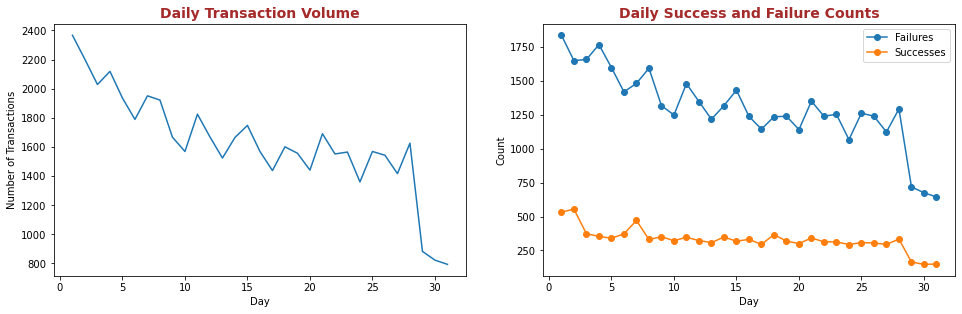

In [9]:
#Resample the data by day for the daily transaction volume
daily_transactions = data.groupby(data['tmsp'].dt.day).size()

#Create a daily count of successes and failures
daily_success = data.groupby([data['tmsp'].dt.day, 'success']).size().unstack(fill_value=0)

#Plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

ax0.plot(daily_transactions.index, daily_transactions.values, label='Transactions')
ax0.set_title('Daily Transaction Volume', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax0.set_xlabel('Day')
ax0.set_ylabel('Number of Transactions')

daily_success.plot(kind='line', marker='o', ax=ax1)
ax1.set_title('Daily Success and Failure Counts', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax1.set_xlabel('Day')
ax1.set_ylabel('Count')
ax1.legend(['Failures', 'Successes'])

plt.tight_layout(pad=3.0)
plt.show()

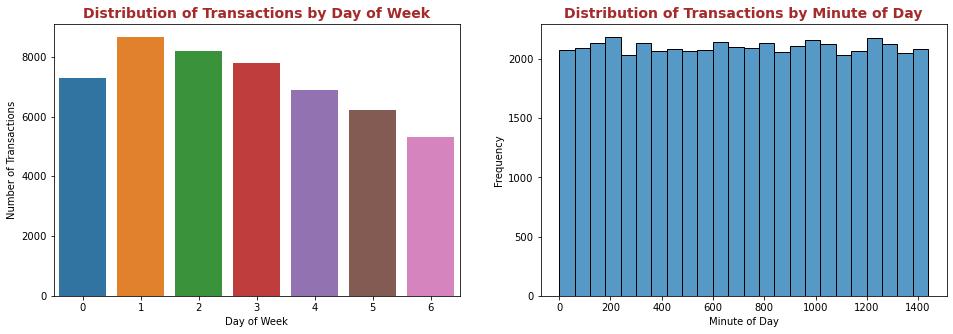

In [10]:
#Define fee structure based on provided information
fee_structure = {'Moneycard': {'success': 5, 'failure': 2},
                 'Goldcard': {'success': 10, 'failure': 5},
                 'UK_Card': {'success': 3, 'failure': 1},
                 'Simplecard': {'success': 1, 'failure': 0.5}}

#Calculate the fees for each transaction
data['fee'] = data.apply(lambda x: fee_structure[x['PSP']]['success'] if x['success'] == 1 else fee_structure[x['PSP']]['failure'], axis=1)

#Extract day of week and minute of day for further analysis
data['day_of_week'] = data['tmsp'].dt.dayofweek
data['minute_of_day'] = data['tmsp'].dt.hour * 60 + data['tmsp'].dt.minute

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

#Distribution by Day of Week
sns.countplot(x='day_of_week', data=data, ax=axs[0])
axs[0].set_title('Distribution of Transactions by Day of Week', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('Number of Transactions')

#Distribution by Minute of Day
sns.histplot(data['minute_of_day'], bins=24, kde=False, ax=axs[1])
axs[1].set_title('Distribution of Transactions by Minute of Day', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
axs[1].set_xlabel('Minute of Day')
axs[1].set_ylabel('Frequency')

plt.show()

In [11]:
#Create a new column 'payment_attempts' and initialize it with 1
data['payment_attempts'] = 1

#Identify rows where consecutive attempts have the same 'country', 'amount', 'minute_of_day' and Increment the 'payment_attempts' for those rows
data['payment_attempts'] = data.groupby(['country', 'amount', 'minute_of_day']).cumcount() + 1

#Reset the DataFrame index
data.reset_index(drop=True, inplace=True)

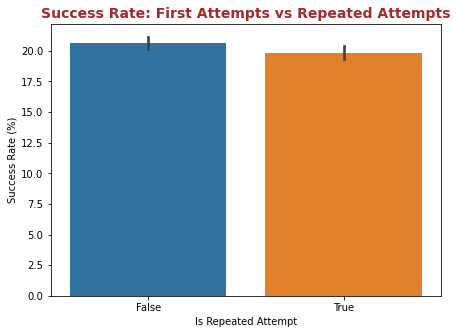

,tmsp,country,amount,PSP,success,3D_secured,card,prev_tmsp,time_diff,is_repeated_attempt
9238,2019-01-10 03:49:12,Austria,6,Moneycard,0,0,Diners,NaT,NaN,False
9239,2019-01-10 03:49:37,Austria,6,Simplecard,0,0,Diners,2019-01-10 03:49:12,25.0,True
22742,2019-01-27 14:01:11,Austria,6,Simplecard,1,0,Master,2019-01-10 03:49:37,1505494.0,False
33737,2019-02-08 05:02:33,Austria,6,UK_Card,0,0,Diners,2019-01-27 14:01:11,1004482.0,False
33738,2019-02-08 05:02:37,Austria,6,UK_Card,0,0,Diners,2019-02-08 05:02:33,4.0,True
33739,2019-02-08 05:02:39,Austria,6,Simplecard,0,0,Diners,2019-02-08 05:02:37,2.0,True
40539,2019-02-16 08:24:40,Austria,6,UK_Card,1,1,Master,2019-02-08 05:02:39,703321.0,False
21179,2019-01-25 04:18:26,Austria,7,Moneycard,0,0,Master,NaT,NaN,False
23798,2019-01-28 23:48:19,Austria,7,UK_Card,0,0,Master,2019-01-25 04:18:26,329393.0,False
31712,2019-02-06 04:09:05,Austria,7,UK_Card,0,0,Diners,2019-01-28 23:48:19,706846.0,False


In [12]:
#Sort the data by country, amount, and timestamp to facilitate finding repeated attempts
data = data.sort_values(by=['country', 'amount', 'tmsp'])

#Create a temporary DataFrame to calculate the time differences
temp_data = data.copy()
temp_data['prev_tmsp'] = temp_data.groupby(['country', 'amount'])['tmsp'].shift(1)
temp_data['time_diff'] = (temp_data['tmsp'] - temp_data['prev_tmsp']).dt.total_seconds()

#Assume attempts within 60 seconds are repeats of the same purchase attempt
temp_data['is_repeated_attempt'] = temp_data['time_diff'].le(60)

#Visualize the success rates of first attempts vs repeated attempts
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x='is_repeated_attempt', y='success', data=temp_data, estimator=lambda x: sum(x) * 100 / len(x))
ax.set_title('Success Rate: First Attempts vs Repeated Attempts', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax.set_xlabel('Is Repeated Attempt')
ax.set_ylabel('Success Rate (%)')
plt.show()

#Display some data about repeated attempts
temp_data[['tmsp', 'country', 'amount', 'PSP', 'success', '3D_secured', 'card', 'prev_tmsp', 'time_diff', 'is_repeated_attempt']].head(10)

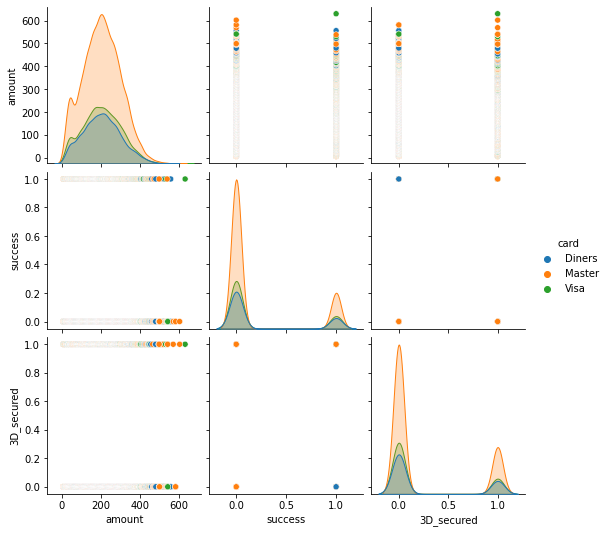

In [13]:
#Interaction Effects of Amount, Success, and 3D Security by Card Type
sns.pairplot(data, vars=['amount', 'success', '3D_secured'], hue='card')
plt.show()

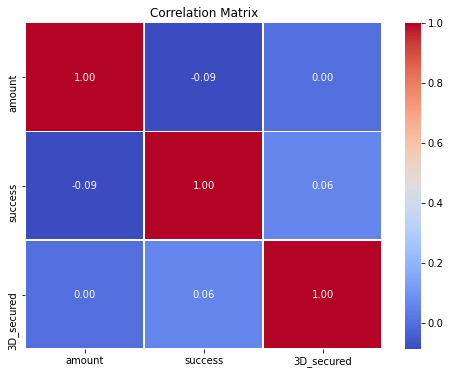

In [14]:
#Correlation matrix of the numerical features
correlation_matrix = data[['amount', 'success', '3D_secured']].corr()

#Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

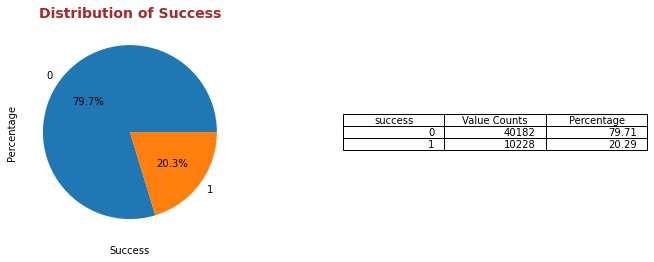

In [15]:
#Proportional Distribution of Transaction Success and Failure
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].pie(data['success'].value_counts(), autopct='%1.1f%%', labels=['0', '1'])
ax[0].set_title('Distribution of Success', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
ax[0].set_xlabel('Success')
ax[0].set_ylabel('Percentage')

table_data = pd.DataFrame({'success': ['0', '1'],
                           'Value Counts': data['success'].value_counts().values, 
                           'Percentage': data['success'].value_counts(normalize=True).values * 100}).round(2)
ax[1].axis('tight')
ax[1].axis('off')
table = ax[1].table(cellText=table_data.values, colLabels=table_data.columns, loc=(0.5, 0.5))
plt.show()

## Data Modeling

In [16]:
data.drop('tmsp', axis=1, inplace=True)
data.head()

,country,amount,success,PSP,3D_secured,card,fee,day_of_week,minute_of_day,payment_attempts
9238,Austria,6,0,Moneycard,0,Diners,2.0,3,229,1
9239,Austria,6,0,Simplecard,0,Diners,0.5,3,229,2
22742,Austria,6,1,Simplecard,0,Master,1.0,6,841,1
33737,Austria,6,0,UK_Card,0,Diners,1.0,4,302,1
33738,Austria,6,0,UK_Card,0,Diners,1.0,4,302,2


In [17]:
#Create a copy of the DataFrame
data1 = data.copy()

#Drop the 'fee' column from the copied DataFrame
data1 = data1.drop('fee', axis=1)
data1

,country,amount,success,PSP,3D_secured,card,day_of_week,minute_of_day,payment_attempts
9238,Austria,6,0,Moneycard,0,Diners,3,229,1
9239,Austria,6,0,Simplecard,0,Diners,3,229,2
22742,Austria,6,1,Simplecard,0,Master,6,841,1
33737,Austria,6,0,UK_Card,0,Diners,4,302,1
33738,Austria,6,0,UK_Card,0,Diners,4,302,2
...,...,...,...,...,...,...,...,...,...
2619,Switzerland,499,0,UK_Card,0,Master,3,247,1
2620,Switzerland,499,0,UK_Card,0,Master,3,247,2
2621,Switzerland,499,0,UK_Card,0,Master,3,248,1
2622,Switzerland,499,0,UK_Card,0,Master,3,248,2


### Baseline Model

In [18]:
def evaluate_model(model, X, y, set_name):
    
    #Make predictions
    y_pred = model.predict(X)
    
    #Calculate performance metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    #Print the performance metrics with set name
    print(f'Model Performance on the {set_name}:')
    print(f'Accuracy: {accuracy:.4f}\tF1-Score: {f1:.4f}\tPrecision: {precision:.4f}\tRecall: {recall:.4f}\tAUC-ROC: {roc_auc:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}\n')

In [19]:
#Encode categorical variables using one-hot encoding
data1_encoded = pd.get_dummies(data1, columns=['country', 'PSP', 'card'])

In [20]:
#Split the dataset into train, validation, and test sets
X_bm = data1_encoded.drop('success', axis=1)
y_bm = data1_encoded['success']

X_bm_train, X_bm_temp, y_bm_train, y_bm_temp = train_test_split(X_bm, y_bm, test_size=0.2, random_state=42)
X_bm_val, X_bm_test, y_bm_val, y_bm_test = train_test_split(X_bm_temp, y_bm_temp, test_size=0.5, random_state=42)

In [21]:
#Create a Logistic Regression model with specified parameters
baseline_lg_model = LogisticRegression(random_state=42)

#Fit the Logistic Regression model on the training set
baseline_lg_model.fit(X_bm_train, y_bm_train)

#Model performance on the validation set
evaluate_model(baseline_lg_model, X_bm_val, y_bm_val, set_name='Validation set - Logistic Regression')

#Model performance on the test set
evaluate_model(baseline_lg_model, X_bm_test, y_bm_test, set_name='Test set - Logistic Regression')

Model Performance on the Validation set - Logistic Regression:
Accuracy: 0.8004	F1-Score: 0.0195	Precision: 0.4762	Recall: 0.0100	AUC-ROC: 0.5036
Confusion Matrix: 
[[4025   11]
 [ 995   10]]

Model Performance on the Test set - Logistic Regression:
Accuracy: 0.7949	F1-Score: 0.0336	Precision: 0.5455	Recall: 0.0174	AUC-ROC: 0.5068
Confusion Matrix: 
[[3989   15]
 [1019   18]]



### Predictive Model

In [22]:
#Encode categorical variables using one-hot encoding
data1 = pd.get_dummies(data1, columns=['country', 'PSP', 'card'])
data1

,amount,success,3D_secured,day_of_week,minute_of_day,payment_attempts,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,card_Visa
9238,6,0,0,3,229,1,1,0,0,0,1,0,0,1,0,0
9239,6,0,0,3,229,2,1,0,0,0,0,1,0,1,0,0
22742,6,1,0,6,841,1,1,0,0,0,0,1,0,0,1,0
33737,6,0,0,4,302,1,1,0,0,0,0,0,1,1,0,0
33738,6,0,0,4,302,2,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,499,0,0,3,247,1,0,0,1,0,0,0,1,0,1,0
2620,499,0,0,3,247,2,0,0,1,0,0,0,1,0,1,0
2621,499,0,0,3,248,1,0,0,1,0,0,0,1,0,1,0
2622,499,0,0,3,248,2,0,0,1,0,0,0,1,0,1,0


In [23]:
#Drop the target variable 'success' from the features
X = data1.drop('success', axis=1)

In [24]:
#Initialize the StandardScaler
scaler = StandardScaler()

#Fit and transform the features using StandardScaler
X_scaled = scaler.fit_transform(X)

#Create a DataFrame with scaled features and include the 'success' column
data1_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data1_scaled['success'] = data1['success']
data1_scaled

,amount,3D_secured,day_of_week,minute_of_day,payment_attempts,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,card_Visa,success
0,-2.039971,-0.55928,0.125262,-1.180246,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,2.252929,-0.57257,-1.051054,2.039786,-1.163927,-0.547934,0
1,-2.039971,-0.55928,0.125262,-1.180246,1.092601,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,2.039786,-1.163927,-0.547934,1
2,-2.039971,-0.55928,1.689662,0.292526,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,-0.490247,0.859160,-0.547934,0
3,-2.039971,-0.55928,0.646728,-1.004572,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,-0.57257,0.951426,2.039786,-1.163927,-0.547934,1
4,-2.039971,-0.55928,0.646728,-1.004572,1.092601,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,-0.57257,0.951426,2.039786,-1.163927,-0.547934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,3.080842,-0.55928,0.125262,-1.136929,-0.531209,-0.492456,-1.224087,1.968803,-0.260698,-0.443867,-0.57257,0.951426,-0.490247,0.859160,-0.547934,0
50406,3.080842,-0.55928,0.125262,-1.136929,1.092601,-0.492456,-1.224087,1.968803,-0.260698,-0.443867,-0.57257,0.951426,-0.490247,0.859160,-0.547934,0
50407,3.080842,-0.55928,0.125262,-1.134522,-0.531209,-0.492456,-1.224087,1.968803,-0.260698,-0.443867,-0.57257,0.951426,-0.490247,0.859160,-0.547934,0
50408,3.080842,-0.55928,0.125262,-1.134522,1.092601,-0.492456,-1.224087,1.968803,-0.260698,-0.443867,-0.57257,0.951426,-0.490247,0.859160,-0.547934,0


In [25]:
#Extract features and target variable for SMOTE
X_smote = data1_scaled.drop('success', axis=1)
y_smote = data1_scaled['success']

#Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

#Create a new DataFrame with the resampled features and the target variable
data1_resampled = pd.DataFrame(X_resampled, columns=X_smote.columns)
data1_resampled['success'] = y_resampled
data1_resampled

,amount,3D_secured,day_of_week,minute_of_day,payment_attempts,country_Austria,country_Germany,country_Switzerland,PSP_Goldcard,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,card_Diners,card_Master,card_Visa,success
0,-2.039971,-0.55928,0.125262,-1.180246,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,2.252929,-0.57257,-1.051054,2.039786,-1.163927,-0.547934,0
1,-2.039971,-0.55928,0.125262,-1.180246,1.092601,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,2.039786,-1.163927,-0.547934,1
2,-2.039971,-0.55928,1.689662,0.292526,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,-0.490247,0.859160,-0.547934,0
3,-2.039971,-0.55928,0.646728,-1.004572,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,-0.57257,0.951426,2.039786,-1.163927,-0.547934,1
4,-2.039971,-0.55928,0.646728,-1.004572,1.092601,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,-0.57257,0.951426,2.039786,-1.163927,-0.547934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80359,-0.963987,-0.55928,0.125262,-1.059018,-0.531209,2.030637,-1.224087,-0.507923,-0.260698,-0.443867,-0.57257,0.951426,-0.490247,-1.163927,1.825036,1
80360,-0.841576,-0.55928,-0.452961,-0.276584,-0.531209,-0.492456,-1.224087,1.968803,-0.260698,2.252929,-0.57257,-1.051054,-0.490247,0.859160,-0.547934,1
80361,-0.570651,-0.55928,0.646728,0.098057,1.092601,-0.492456,0.816935,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,2.039786,-1.163927,-0.547934,1
80362,0.446815,-0.55928,0.646728,0.218460,-0.531209,-0.492456,0.816935,-0.507923,-0.260698,-0.443867,1.74651,-1.051054,-0.490247,0.859160,-0.547934,1


In [26]:
#Split the dataset into train, validation, and test sets
X_1 = data1_resampled.drop('success', axis=1)
y_1 = data1_resampled['success']

X_train_1, X_temp, y_train_1, y_temp = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
#Initialize a StandardScaler and scale the features for training, validation, and test sets
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_valid_scaled_1 = scaler.transform(X_valid_1)
X_test_scaled_1 = scaler.transform(X_test_1)

In [28]:
#Define a function to evaluate the performance of a model
def evaluate_model(model, X_scaled, y, set_name):
    y_pred = model.predict(X_scaled)
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]
    
    #Calculate and print relevant evaluation metrics
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    print(f'{set_name} Set Evaluation')
    print(f'Accuracy: {accuracy:.4f}\tF1-Score: {f1:.4f}\tPrecision: {precision:.4f}\tRecall: {recall:.4f}\tAUC-ROC: {roc_auc:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}\n')

In [29]:
#Create a Random Forest model with specified parameters
rf_model1 = RandomForestClassifier(random_state=42)

#Fit the Random Forest model on the training set
rf_model1.fit(X_train_scaled_1, y_train_1)

#Model performance on the validation set
evaluate_model(rf_model1, X_valid_scaled_1, y_valid_1, set_name='Random Forest - Validation')

#Model performance on the test set
evaluate_model(rf_model1, X_test_scaled_1, y_test_1, set_name='Random Forest - Test')

Random Forest - Validation Set Evaluation
Accuracy: 0.7766	F1-Score: 0.7722	Precision: 0.7752	Recall: 0.7692	AUC-ROC: 0.8453
Confusion Matrix: 
[[3199  882]
 [ 913 3042]]

Random Forest - Test Set Evaluation
Accuracy: 0.7818	F1-Score: 0.7797	Precision: 0.7916	Recall: 0.7681	AUC-ROC: 0.8493
Confusion Matrix: 
[[3179  817]
 [ 937 3104]]



#### Random Forest Classification with Cross-Validation and Hyperparameter Tuning

In [30]:
#Create a Random Forest model with a set random state
rf_model1 = RandomForestClassifier(random_state=42)

#Define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

#Create GridSearchCV
grid_search = GridSearchCV(estimator=rf_model1, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

#Fit the model on the training data
grid_search.fit(X_train_scaled_1, y_train_1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [31]:
#Print the best parameters and best score
print('Best Parameters:', grid_search.best_params_)
print('Best Score:', grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.7634349750178755


In [32]:
#Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

In [33]:
#Evaluate the best model on the validation and test sets
evaluate_model(best_rf_model, X_valid_scaled_1, y_valid_1, set_name='Random Forest - Validation')
evaluate_model(best_rf_model, X_test_scaled_1, y_test_1, set_name='Random Forest - Test')

Random Forest - Validation Set Evaluation
Accuracy: 0.7761	F1-Score: 0.7714	Precision: 0.7754	Recall: 0.7674	AUC-ROC: 0.8468
Confusion Matrix: 
[[3202  879]
 [ 920 3035]]

Random Forest - Test Set Evaluation
Accuracy: 0.7836	F1-Score: 0.7821	Precision: 0.7923	Recall: 0.7721	AUC-ROC: 0.8512
Confusion Matrix: 
[[3178  818]
 [ 921 3120]]



#### Summary bar plot of the importance of individual features in Model 1

In [34]:
#Create a SHAP TreeExplainer for the best random forest Model 1
explainer = shap.TreeExplainer(best_rf_model)

#Obtain SHAP values for the validation set
shap_values = explainer.shap_values(X_valid_scaled_1)

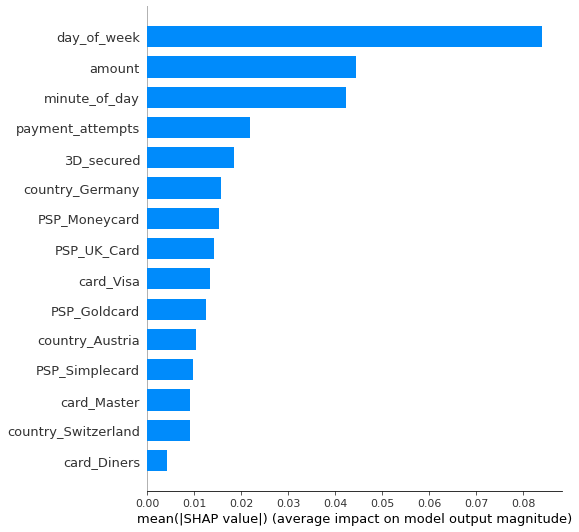

In [35]:
#Define feature names for summary plot
feature_names = ['amount', '3D_secured', 'day_of_week', 'minute_of_day', 'payment_attempts',
                 'country_Austria', 'country_Germany', 'country_Switzerland', 'card_Diners', 'card_Master', 'card_Visa',
                 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'PSP_Goldcard', 'success']

#Create a summary plot using SHAP values
shap.summary_plot(shap_values[1], X_valid_scaled_1, feature_names=feature_names, plot_type='bar', show=False)
plt.show()

#### Precision-Recall Curve for validation and test set of Model 1

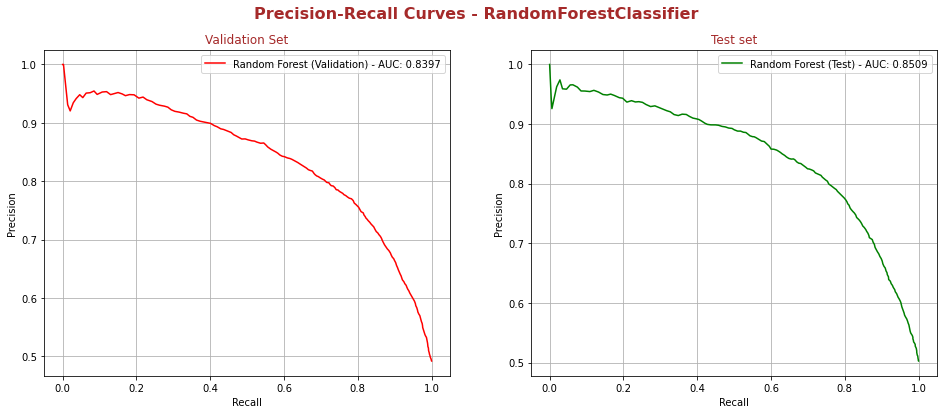

In [36]:
#Predict probabilities on the validation and test set
y_valid_pred_proba = best_rf_model.predict_proba(X_valid_scaled_1)[:, 1]
y_test_pred_proba = best_rf_model.predict_proba(X_test_scaled_1)[:, 1]

#Compute precision-recall curve values for validation and test set
precision_valid, recall_valid, thresholds_valid = precision_recall_curve(y_valid_1, y_valid_pred_proba)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test_1, y_test_pred_proba)

#Compute area under the curve (AUC) for validation and test set
pr_auc_valid = auc(recall_valid, precision_valid)
pr_auc_test = auc(recall_test, precision_test)

#Plot the precision-recall curve for validation and test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(recall_valid, precision_valid, color='red', label=f'Random Forest (Validation) - AUC: {pr_auc_valid:.4f}')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Validation Set', color='brown')
ax1.legend()
ax1.grid(True)

ax2.plot(recall_test, precision_test, color='green', label=f'Random Forest (Test) - AUC: {pr_auc_test:.4f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Test set', color='brown')
ax2.legend()
ax2.grid(True)

plt.suptitle('Precision-Recall Curves - RandomForestClassifier', fontsize=16, fontweight='bold', color='brown')
plt.show()

In [37]:
#Impact of threshold adjustment on Precision and Recall metrics of Model 1
def evaluate_model(model, X, y, set_name=''):
    '''
    Evaluate the performance of a classification model on a given dataset.

    Parameters:
    - model: The trained classification model.
    - X: The feature matrix of the dataset.
    - y: The true labels of the dataset.
    - set_name: The name of the dataset (e.g., 'Train', 'Validation', 'Test').

    Prints:
    - Accuracy, Precision, Recall, F1 Score, ROC AUC Score, Confusion Matrix.
    '''
    #Make predictions
    y_pred = model.predict(X)

    #Convert y to 1D array if it's a DataFrame
    if hasattr(y, 'values'):
        y = y.values.ravel()

    #Calculate and print relevant evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    roc_auc = roc_auc_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f'{set_name} Set Evaluation:')
    print(f'Accuracy: {accuracy:.4f}\tF1-Score: {f1:.4f}\tPrecision: {precision:.4f}\tRecall: {recall:.4f}\tAUC-ROC: {roc_auc:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}\n')

In [38]:
#Predict probabilities on the validation set
y_valid_pred_proba = best_rf_model.predict_proba(X_valid_scaled_1)[:, 1]

#Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_valid_1, y_valid_pred_proba)

#The threshold balance between precision and recall
desired_precision = 0.85
desired_recall = 0.85

#The index of the point on the curve closest to the desired trade-off
closest_point_index = np.argmin(np.abs(precision - desired_precision) + np.abs(recall - desired_recall))

#Get the corresponding threshold
desired_threshold = thresholds[closest_point_index]
print(f'Desired Threshold: {desired_threshold:.4f}')

Desired Threshold: 0.4050


In [39]:
#Adjust the decision threshold for the validation set
adjusted_predictions_valid = (y_valid_pred_proba >= desired_threshold).astype(int)

#Now, use the adjusted predictions in your evaluation or downstream tasks for the validation set
evaluate_model(best_rf_model, X_valid_scaled_1, y_valid_1, set_name='Validation with Adjusted Threshold')

Validation with Adjusted Threshold Set Evaluation:
Accuracy: 0.7761	F1-Score: 0.7761	Precision: 0.7761	Recall: 0.7761	AUC-ROC: 0.7760
Confusion Matrix: 
[[3202  879]
 [ 920 3035]]



In [40]:
#Predict probabilities on the test set
y_test_pred_proba = best_rf_model.predict_proba(X_test_scaled_1)[:, 1]

#Adjust the decision threshold for the test set
adjusted_predictions_test = (y_test_pred_proba >= desired_threshold).astype(int)

#Use the adjusted predictions in your evaluation or downstream tasks for the test set
evaluate_model(best_rf_model, X_test_scaled_1, y_test_1, set_name='Test with Adjusted Threshold')

Test with Adjusted Threshold Set Evaluation:
Accuracy: 0.7836	F1-Score: 0.7836	Precision: 0.7838	Recall: 0.7836	AUC-ROC: 0.7837
Confusion Matrix: 
[[3178  818]
 [ 921 3120]]



#### ROC Curve on validation and test set of Model 1

In [41]:
#Get probabilities on the validation set
y_valid_pred_proba = best_rf_model.predict_proba(X_valid_scaled_1)[:, 1]

#Get probabilities on the test set
y_test_pred_proba = best_rf_model.predict_proba(X_test_scaled_1)[:, 1]

#Adjust the decision threshold for both validation and test sets
adjusted_threshold = 0.445
adjusted_predictions_valid = (y_valid_pred_proba >= adjusted_threshold).astype(int)
adjusted_predictions_test = (y_test_pred_proba >= adjusted_threshold).astype(int)

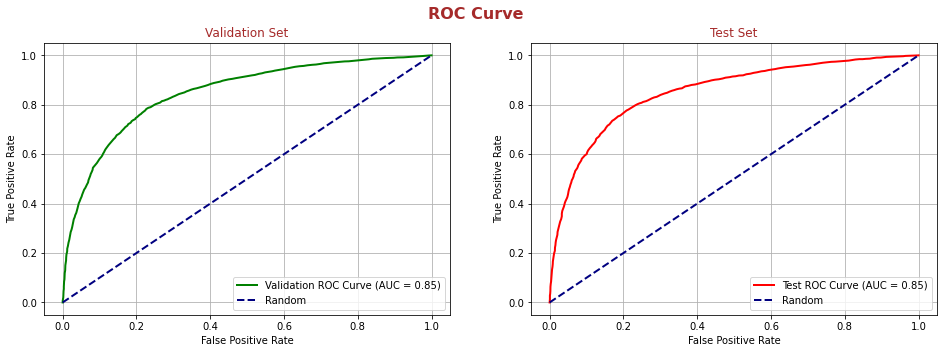

In [42]:
#Compute ROC Curve for both validation and test sets
fpr_valid, tpr_valid, _ = roc_curve(y_valid_1, y_valid_pred_proba)
roc_auc_valid = auc(fpr_valid, tpr_valid)

fpr_test, tpr_test, _ = roc_curve(y_test_1, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

#Plot ROC Curve for Validation and test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(fpr_valid, tpr_valid, color='green', lw=2, label=f'Validation ROC Curve (AUC = {roc_auc_valid:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Validation Set', color='brown')
ax1.legend()
ax1.grid(True)

ax2.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Test Set', color='brown')
ax2.legend()
ax2.grid(True)

plt.suptitle('ROC Curve', fontsize=16, fontweight='bold', color='brown')
plt.show()

#### Pie chart for analyzing correctly classified and misclassified of Model 1

Total Correctly Classified Instances on Validation Set of model 1: 6237
Total Misclassified Instances on Validation Set of model 1: 1799


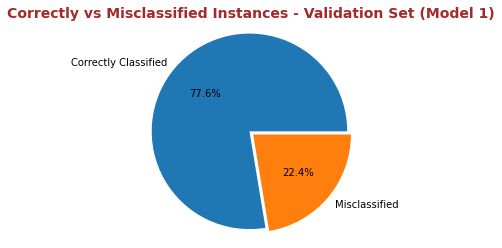

In [43]:
#Confusion matrix of Model 1 on Validation Set
confusion_matrix = np.array([[3202, 879], 
                             [920, 3035]])

#Calculate total correctly classified and misclassified instances
correctly_classified = np.trace(confusion_matrix)
misclassified = np.sum(confusion_matrix) - correctly_classified

print('Total Correctly Classified Instances on Validation Set of model 1:', correctly_classified)
print('Total Misclassified Instances on Validation Set of model 1:', misclassified)

#Plot a pie chart
plt.pie([correctly_classified, misclassified], explode=(0.05, 0), labels=['Correctly Classified', 'Misclassified'], autopct='%1.1f%%')
plt.axis('equal') 
plt.title('Correctly vs Misclassified Instances - Validation Set (Model 1)', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.show()

Total Correctly Classified Instances on Test Set of model 1: 6298
Total Misclassified Instances on Test Set of model 1: 1739


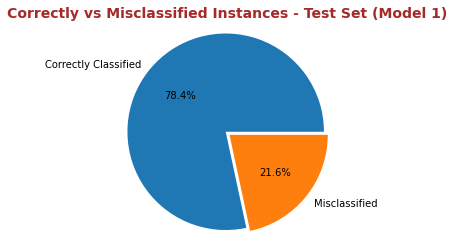

In [44]:
#Confusion matrix of Model 1 on Test Set
confusion_matrix = np.array([[3178, 818], 
                             [921, 3120]])

#Calculate total correctly classified and misclassified instances
correctly_classified = np.trace(confusion_matrix)
misclassified = np.sum(confusion_matrix) - correctly_classified

print('Total Correctly Classified Instances on Test Set of model 1:', correctly_classified)
print('Total Misclassified Instances on Test Set of model 1:', misclassified)

#Plot a pie chart
plt.pie([correctly_classified, misclassified], explode=(0.05, 0), labels=['Correctly Classified', 'Misclassified'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Correctly vs Misclassified Instances - Test Set (Model 1)', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.show()

In [45]:
#Access cross-validation results
cv_results = grid_search.cv_results_

#Print performance metrics for each fold
for i in range(grid_search.n_splits_):
    print(f'\nResults for Fold {i + 1}:')
    print(f"Mean Test Score: {cv_results[f'mean_test_score'][i]}")
    print(f"Standard Deviation Test Score: {cv_results[f'std_test_score'][i]}")
    print(f"Params: {cv_results['params'][i]}")


Results for Fold 1:
Mean Test Score: 0.7586442631278765
Standard Deviation Test Score: 0.001499016689174784
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Results for Fold 2:
Mean Test Score: 0.7611640528023348
Standard Deviation Test Score: 0.0018177565528711371
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Results for Fold 3:
Mean Test Score: 0.7634349750178755
Standard Deviation Test Score: 0.001643541719901728
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Results for Fold 4:
Mean Test Score: 0.7567777450897818
Standard Deviation Test Score: 0.002299624219386114
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Results for Fold 5:
Mean Test Score: 0.7604485776070744
Standard Deviation Test Score: 0.003071340034048997
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 

#### Overfitting Analysis for Model 1

In [46]:
#Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('F1 Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='Cross-validation score')
    plt.legend(loc='best')
    return plt

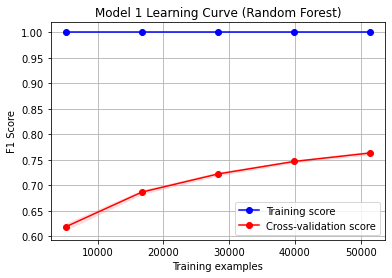

In [47]:
#Plot learning curve
plot_learning_curve(best_rf_model, 'Model 1 Learning Curve (Random Forest)', X_train_scaled_1, y_train_1, cv=5)
plt.show()

### Model 2

In [48]:
#Drop 'success' and 'fee' columns from the baseline model dataFrame
X_bm = data.drop(['success', 'fee'], axis=1)

In [49]:
#One-hot encode the categorical columns
X_bm_encoded = pd.get_dummies(X_bm, columns=['country', 'PSP', 'card'])

In [50]:
#Identify additional columns in X_bm_encoded not present in X_train_1
additional_columns = set(X_bm_encoded.columns) - set(X_train_1.columns)
if additional_columns:
    print(f'Additional columns in X_bm_encoded: {additional_columns}')
    
#Identify missing columns in X_bm_encoded compared to X_train_1
missing_columns = set(X_train_1.columns) - set(X_bm_encoded.columns)
if missing_columns:
    print(f'Missing columns in X_bm_encoded: {missing_columns}')
    
#Keep only columns present in X_train_1 in X_bm_encoded
X_bm_encoded = X_bm_encoded[X_train_1.columns]

In [51]:
#Scale the features using the previously defined 'scaler'
X_bm_scaled = scaler.transform(X_bm_encoded)

In [52]:
#Add success probabilities as new columns using the trained random forest Model 1
data['success_probabilities'] = best_rf_model.predict_proba(X_bm_scaled)[:, 1]
data.head()

,country,amount,success,PSP,3D_secured,card,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities
9238,Austria,6,0,Moneycard,0,Diners,2.0,3,229,1,0.350
9239,Austria,6,0,Simplecard,0,Diners,0.5,3,229,2,0.355
22742,Austria,6,1,Simplecard,0,Master,1.0,6,841,1,0.350
33737,Austria,6,0,UK_Card,0,Diners,1.0,4,302,1,0.355
33738,Austria,6,0,UK_Card,0,Diners,1.0,4,302,2,0.345


In [53]:
#Create a copy of the DataFrame
data2 = data.copy()
data2

,country,amount,success,PSP,3D_secured,card,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities
9238,Austria,6,0,Moneycard,0,Diners,2.0,3,229,1,0.350
9239,Austria,6,0,Simplecard,0,Diners,0.5,3,229,2,0.355
22742,Austria,6,1,Simplecard,0,Master,1.0,6,841,1,0.350
33737,Austria,6,0,UK_Card,0,Diners,1.0,4,302,1,0.355
33738,Austria,6,0,UK_Card,0,Diners,1.0,4,302,2,0.345
...,...,...,...,...,...,...,...,...,...,...,...
2619,Switzerland,499,0,UK_Card,0,Master,1.0,3,247,1,0.450
2620,Switzerland,499,0,UK_Card,0,Master,1.0,3,247,2,0.410
2621,Switzerland,499,0,UK_Card,0,Master,1.0,3,248,1,0.450
2622,Switzerland,499,0,UK_Card,0,Master,1.0,3,248,2,0.410


### Baseline Model 2

In [54]:
#Encode categorical variables using one-hot encoding
data2_encoded = pd.get_dummies(data2, columns=['country', 'card'])
data2_encoded.head()

,amount,success,PSP,3D_secured,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
9238,6,0,Moneycard,0,2.0,3,229,1,0.350,1,0,0,1,0,0
9239,6,0,Simplecard,0,0.5,3,229,2,0.355,1,0,0,1,0,0
22742,6,1,Simplecard,0,1.0,6,841,1,0.350,1,0,0,0,1,0
33737,6,0,UK_Card,0,1.0,4,302,1,0.355,1,0,0,1,0,0
33738,6,0,UK_Card,0,1.0,4,302,2,0.345,1,0,0,1,0,0


In [55]:
#Split the dataset into train, validation, and test sets
X = data2_encoded.drop(['PSP', 'success'], axis=1)
y = data2_encoded['PSP']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [56]:
from sklearn.metrics import confusion_matrix
def evaluate_model(model, X, y, set_name):
    
    #Making predictions
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, 'predict_proba') else None
    
    #Calculating performance metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='micro')
    recall = recall_score(y, y_pred, average='micro')
    f1 = f1_score(y, y_pred, average='micro')
    roc_auc = roc_auc_score(y, y_proba, multi_class='ovr') if y_proba is not None else None
    conf_matrix = confusion_matrix(y, y_pred)
    
    #Printing the performance metrics with set name
    print(f'Model Performance on the {set_name}:')
    print(f'Accuracy: {accuracy:.4f}\tF1-Score: {f1:.4f}\tPrecision: {precision:.4f}\tRecall: {recall:.4f}')
    if roc_auc is not None:
        print(f'AUC-ROC: {roc_auc:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}\n')

In [57]:
#Create and train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

#Evaluate the KNN model on the validation set
evaluate_model(knn_model, X_val, y_val, set_name='Validation set - KNN')

#Evaluate the KNN model on the test set
evaluate_model(knn_model, X_test, y_test, set_name='Test set - KNN')

Model Performance on the Validation set - KNN:
Accuracy: 0.4398	F1-Score: 0.4398	Precision: 0.4398	Recall: 0.4398
AUC-ROC: 0.5868
Confusion Matrix: 
[[  38   62   31  170]
 [  16  133  141  507]
 [   1  163  327  807]
 [  12  326  588 1719]]

Model Performance on the Test set - KNN:
Accuracy: 0.4293	F1-Score: 0.4293	Precision: 0.4293	Recall: 0.4293
AUC-ROC: 0.5684
Confusion Matrix: 
[[  47   58   32  177]
 [  14  143  147  537]
 [   7  146  291  804]
 [  10  346  599 1683]]



### Predictive Model 2

In [58]:
#Encode categorical variables using one-hot encoding
data2_encoded = pd.get_dummies(data2, columns=['country', 'card'])
data2_encoded.head()

,amount,success,PSP,3D_secured,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
9238,6,0,Moneycard,0,2.0,3,229,1,0.350,1,0,0,1,0,0
9239,6,0,Simplecard,0,0.5,3,229,2,0.355,1,0,0,1,0,0
22742,6,1,Simplecard,0,1.0,6,841,1,0.350,1,0,0,0,1,0
33737,6,0,UK_Card,0,1.0,4,302,1,0.355,1,0,0,1,0,0
33738,6,0,UK_Card,0,1.0,4,302,2,0.345,1,0,0,1,0,0


In [59]:
#Drop the target variables 'PSP' and 'success' from the features
X_2 = data2_encoded.drop(['PSP', 'success'], axis=1)

In [60]:
#Initialize the StandardScaler
scaler = StandardScaler()

#Fit and transform the features using StandardScaler
X_scaled_2 = scaler.fit_transform(X_2)

#Create a DataFrame with scaled features and include the 'PSP' column
data2_scaled = pd.DataFrame(X_scaled_2, columns=X_2.columns)
data2_scaled[['PSP']] = data2_encoded[['PSP']]
data2_scaled.head()

,amount,3D_secured,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa,PSP
0,-2.039971,-0.55928,0.134244,0.125262,-1.180246,-0.531209,-0.639602,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
1,-2.039971,-0.55928,-0.692643,0.125262,-1.180246,1.092601,-0.557571,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
2,-2.039971,-0.55928,-0.417014,1.689662,0.292526,-0.531209,-0.639602,2.030637,-1.224087,-0.507923,-0.490247,0.859160,-0.547934,UK_Card
3,-2.039971,-0.55928,-0.417014,0.646728,-1.004572,-0.531209,-0.557571,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
4,-2.039971,-0.55928,-0.417014,0.646728,-1.004572,1.092601,-0.721634,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,Simplecard


In [61]:
#Split the scaled DataFrame into features (X_smote_2) and target variable (y_smote_2)
X_smote_2 = data2_scaled.drop('PSP', axis=1)
y_smote_2 = data2_scaled['PSP']

#Initialize the SMOTE with a random state
smote_2 = SMOTE(random_state=42)

#Resample the dataset using SMOTE
X_resampled_2, y_resampled_2 = smote_2.fit_resample(X_smote_2, y_smote_2)

#Create a DataFrame with resampled features and include the 'PSP' column
data2_resampled = pd.DataFrame(X_resampled_2, columns=X_smote_2.columns)
data2_resampled['PSP'] = y_resampled_2
data2_resampled.head()

,amount,3D_secured,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa,PSP
0,-2.039971,-0.55928,0.134244,0.125262,-1.180246,-0.531209,-0.639602,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
1,-2.039971,-0.55928,-0.692643,0.125262,-1.180246,1.092601,-0.557571,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
2,-2.039971,-0.55928,-0.417014,1.689662,0.292526,-0.531209,-0.639602,2.030637,-1.224087,-0.507923,-0.490247,0.859160,-0.547934,UK_Card
3,-2.039971,-0.55928,-0.417014,0.646728,-1.004572,-0.531209,-0.557571,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,UK_Card
4,-2.039971,-0.55928,-0.417014,0.646728,-1.004572,1.092601,-0.721634,2.030637,-1.224087,-0.507923,2.039786,-1.163927,-0.547934,Simplecard


In [62]:
#Split the dataset into train, validation, and test sets
X_2 = data2_resampled.drop('PSP', axis=1)
y_2 = data2_resampled['PSP']

X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
X_valid_2, X_test_2, y_valid_2, y_test_2 = train_test_split(X_temp_2, y_temp_2, test_size=0.5, random_state=42)

In [63]:
#Initialize a StandardScaler and scale the features for training, validation, and test sets
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_valid_scaled_2 = scaler.transform(X_valid_2)
X_test_scaled_2 = scaler.transform(X_test_2)

In [64]:
#Define a function to evaluate the performance of a model
def evaluate_model(model, X, y, set_name):
    y_pred = model.predict(X)
    y_values = y.values.ravel()

    #Calculate and print relevant evaluation metrics
    precision = precision_score(y_values, y_pred, average='weighted')
    recall = recall_score(y_values, y_pred, average='weighted')
    f1 = f1_score(y_values, y_pred, average='weighted')   

    #For binary classification, set multi_class to 'ovr'
    if len(model.classes_) == 2:
        roc_auc = roc_auc_score(y_values, model.predict_proba(X)[:, 1], average='weighted')
    else:
        roc_auc = roc_auc_score(pd.get_dummies(y_values), model.predict_proba(X), average='weighted', multi_class='ovr')
    
    conf_matrix = confusion_matrix(y_values, y_pred)
    accuracy = accuracy_score(y_values, y_pred) 
    
    print(f'{set_name} Set Evaluation:')
    print(f'Accuracy: {accuracy:.4f}\tF1-Score: {f1:.4f}\tPrecision: {precision:.4f}\tRecall: {recall:.4f}\tAUC-ROC: {roc_auc:.4f}')
    print(f'Confusion Matrix: \n{conf_matrix}\n')

In [65]:
#Create a Decision Tree model with specified parameters
dt_model = DecisionTreeClassifier(random_state=42, max_depth=None)

#Fit the Decision Tree model on the training set
dt_model.fit(X_train_scaled_2, y_train_2)

#Print model performance on the validation set
evaluate_model(dt_model, X_valid_scaled_2, y_valid_2, set_name='Decision Tree - Validation')

#Print model performance on the test set
evaluate_model(dt_model, X_test_scaled_2, y_test_2, set_name='Decision Tree - Test')

Decision Tree - Validation Set Evaluation:
Accuracy: 0.5154	F1-Score: 0.5144	Precision: 0.5138	Recall: 0.5154	AUC-ROC: 0.6768
Confusion Matrix: 
[[1772  328  313  196]
 [ 358 1320  537  483]
 [ 351  488 1152  650]
 [ 259  477  689 1211]]

Decision Tree - Test Set Evaluation:
Accuracy: 0.5173	F1-Score: 0.5167	Precision: 0.5165	Recall: 0.5173	AUC-ROC: 0.6782
Confusion Matrix: 
[[1760  361  280  226]
 [ 360 1298  500  491]
 [ 288  446 1212  639]
 [ 276  544  698 1205]]



In [66]:
#Perform cross-validation on the training set
cv_scores_dt = cross_val_score(dt_model, X_train_scaled_2, y_train_2, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5))
print('Cross-Validation Scores - Decision Tree:')
print(cv_scores_dt)
print(f'Average F1 Weighted Score: {cv_scores_dt.mean():.4f}\n')

Cross-Validation Scores - Decision Tree:
[0.49740491 0.48924901 0.49154031 0.49058439 0.49359644]
Average F1 Weighted Score: 0.4925



In [67]:
#Create a Random Forest model with specified parameters
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)

#Fit the Random Forest model on the training set
rf_model.fit(X_train_scaled_2, y_train_2)

#Print model performance on the validation set
evaluate_model(rf_model, X_valid_scaled_2, y_valid_2, set_name='Random Forest - Validation')

#Print model performance on the test set
evaluate_model(rf_model, X_test_scaled_2, y_test_2, set_name='Random Forest - Test')

Random Forest - Validation Set Evaluation:
Accuracy: 0.6175	F1-Score: 0.6146	Precision: 0.6140	Recall: 0.6175	AUC-ROC: 0.8345
Confusion Matrix: 
[[2166  145  134  164]
 [ 280 1601  353  464]
 [ 276  359 1315  691]
 [ 181  402  599 1454]]

Random Forest - Test Set Evaluation:
Accuracy: 0.6207	F1-Score: 0.6186	Precision: 0.6176	Recall: 0.6207	AUC-ROC: 0.8375
Confusion Matrix: 
[[2150  162  135  180]
 [ 261 1609  315  464]
 [ 244  347 1332  662]
 [ 179  418  648 1478]]



In [68]:
#Perform cross-validation on the training set
cv_scores_rf = cross_val_score(rf_model, X_train_scaled_2, y_train_2, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5))
print('Cross-Validation Scores:')
print(cv_scores_rf)
print(f'Average F1 Weighted Score: {cv_scores_rf.mean():.4f}\n')

Cross-Validation Scores:
[0.59774425 0.6033739  0.60142826 0.60464018 0.60500555]
Average F1 Weighted Score: 0.6024



#### Random Forest Model 2 Classification with Cross-Validation and Hyperparameter Tuning

In [69]:
#Create a Random Forest model with a set random state
rf_model = RandomForestClassifier(random_state=42)

#Define the parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}

#Use GridSearchCV for hyperparameter tuning
rf_grid = GridSearchCV(rf_model, param_grid, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5), verbose=1)
rf_grid.fit(X_train_scaled_2, y_train_2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted', verbose=1)

In [70]:
#Get the best model from the grid search
rf_best_model = rf_grid.best_estimator_
print('Best Hyperparameters:', rf_grid.best_params_)

Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}


In [71]:
#Perform cross-validation on the training set with the best model
cv_scores_rf = cross_val_score(rf_best_model, X_train_scaled_2, y_train_2, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5))
print('Cross-Validation Scores with Best Model of Random Forest Classification:')
print(cv_scores_rf)
print(f'Average F1 Weighted Score: {cv_scores_rf.mean():.4f}\n')

Cross-Validation Scores with Best Model of Random Forest Classification:
[0.60023359 0.6046809  0.60461586 0.60901985 0.60678219]
Average F1 Weighted Score: 0.6051



In [72]:
#Fit the best Random Forest model on the training set
rf_best_model.fit(X_train_scaled_2, y_train_2)

#Print model performance on the validation set
evaluate_model(rf_best_model, X_valid_scaled_2, y_valid_2, set_name='Random Forest - Validation')

#Print model performance on the test set
evaluate_model(rf_best_model, X_test_scaled_2, y_test_2, set_name='Random Forest - Test')

Random Forest - Validation Set Evaluation:
Accuracy: 0.6196	F1-Score: 0.6168	Precision: 0.6162	Recall: 0.6196	AUC-ROC: 0.8367
Confusion Matrix: 
[[2178  139  129  163]
 [ 267 1609  357  465]
 [ 259  363 1317  702]
 [ 183  394  605 1454]]

Random Forest - Test Set Evaluation:
Accuracy: 0.6227	F1-Score: 0.6211	Precision: 0.6205	Recall: 0.6227	AUC-ROC: 0.8401
Confusion Matrix: 
[[2144  162  137  184]
 [ 254 1619  317  459]
 [ 228  333 1339  685]
 [ 176  407  651 1489]]



#### Summary bar plot of the importance of individual features in Model 2

In [73]:
#Create a SHAP TreeExplainer for the best Random Forest Model 2
explainer = shap.TreeExplainer(rf_best_model)

#Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_valid_scaled_2)

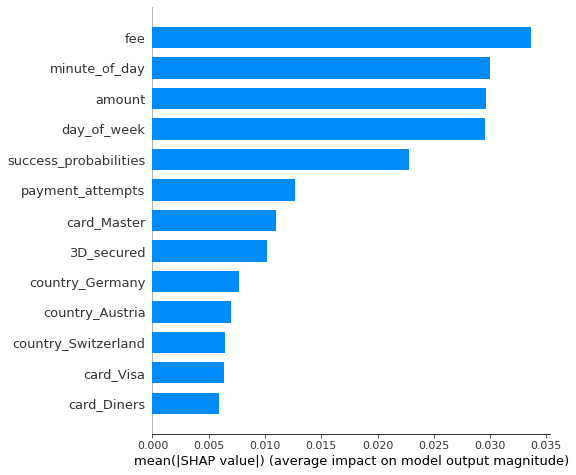

In [74]:
#Define the feature names 
feature_names = ['amount', '3D_secured', 'fee', 'day_of_week', 'minute_of_day','payment_attempts', 
                 'success_probabilities', 'country_Austria', 'country_Germany', 'country_Switzerland', 
                 'card_Diners', 'card_Master', 'card_Visa', 'PSP']

#Create a summary plot of SHAP values
shap.summary_plot(shap_values[1], X_valid_scaled_2, feature_names=feature_names, plot_type='bar', show=False)
plt.show()

#### Precision-Recall curve for validation and test set of Model 2

In [75]:
from sklearn.preprocessing import label_binarize

#Binarize the labels for precision-recall curve
y_valid_2_bin = label_binarize(y_valid_2, classes=np.unique(y_valid_2))
y_test_2_bin = label_binarize(y_test_2, classes=np.unique(y_test_2))

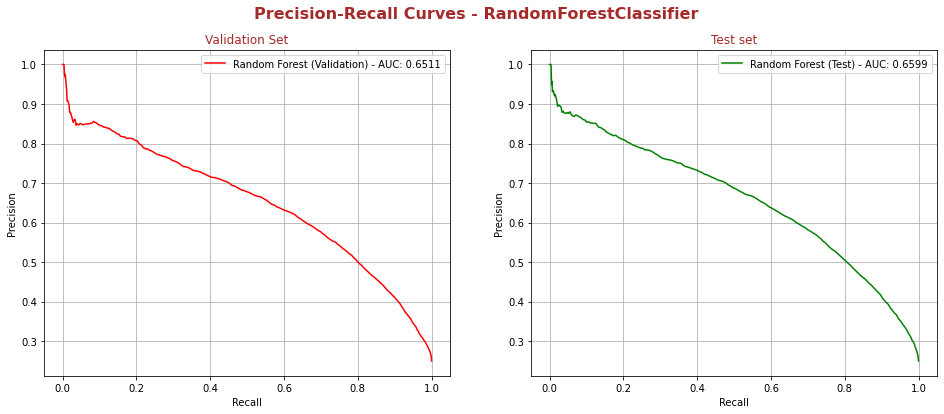

In [76]:
#Predict probabilities on the validation and test set
y_valid_pred_proba_rf = rf_best_model.predict_proba(X_valid_scaled_2)
y_test_pred_proba_rf = rf_best_model.predict_proba(X_test_scaled_2)

#Calculate precision and recall for various thresholds
precision_rf_valid, recall_rf_valid, thresholds_rf_valid = precision_recall_curve(y_valid_2_bin.ravel(), y_valid_pred_proba_rf.ravel())
precision_rf_test, recall_rf_test, thresholds_rf_test = precision_recall_curve(y_test_2_bin.ravel(), y_test_pred_proba_rf.ravel())

#Calculate AUC for validation and test set
auc_rf_valid = auc(recall_rf_valid, precision_rf_valid)
auc_rf_test = auc(recall_rf_test, precision_rf_test)

#Plot the precision-recall curve for validation and test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(recall_rf_valid, precision_rf_valid, color='red', label=f'Random Forest (Validation) - AUC: {auc_rf_valid:.4f}')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Validation Set', color='brown')
ax1.legend()
ax1.grid(True)

ax2.plot(recall_rf_test, precision_rf_test, color='green', label=f'Random Forest (Test) - AUC: {auc_rf_test:.4f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Test set', color='brown')
ax2.legend()
ax2.grid(True)

plt.suptitle('Precision-Recall Curves - RandomForestClassifier', fontsize=16, fontweight='bold', color='brown')
plt.show()

#### ROC Curve on validation and test set of Model 2

In [77]:
def evaluate_model_with_roc(model, X, y, set_name='Set'):
    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y)
    y_pred_prob = model.predict_proba(X)

    #Compute ROC curve and ROC area for each class
    n_classes = y_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Random Forest ROC Curve - {set_name}', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
    plt.legend(loc='lower right')
    plt.show()

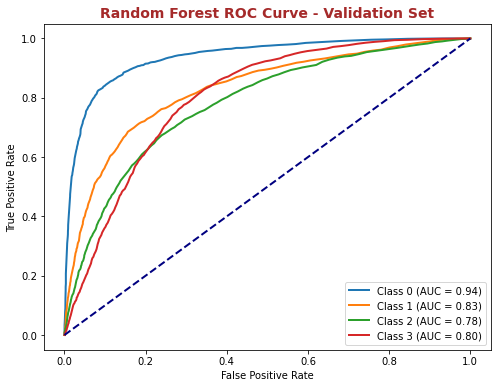

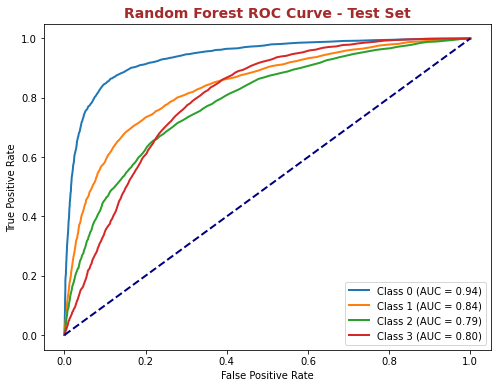

In [78]:
#Evaluate on Validation Set with ROC Curve
evaluate_model_with_roc(rf_best_model, X_valid_scaled_2, y_valid_2, set_name='Validation Set')

#Evaluate on Test Set with ROC Curve
evaluate_model_with_roc(rf_best_model, X_test_scaled_2, y_test_2, set_name='Test Set')

#### Pie chart for analyzing correctly and misclassified classified on the validation and test set of Model  2

Total Correctly Classified Instances on validation set of model 2: 6558
Total Misclassified Instances on validation set of model 2: 4026


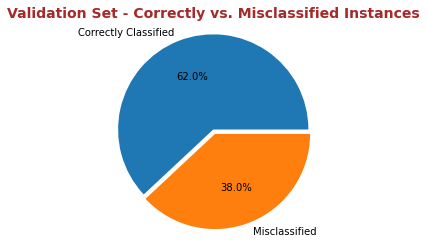

In [79]:
conf_matrix = np.array([[2178, 139, 129, 163],
                        [267, 1609, 357, 465],
                        [259, 363, 1317, 702],
                        [183, 394, 605, 1454]])

#Calculate total correctly classified instances
correctly_classified_total = np.sum(np.diag(conf_matrix))
print(f'Total Correctly Classified Instances on validation set of model 2: {correctly_classified_total}')

#Calculate total misclassified instances
misclassified_total = np.sum(conf_matrix) - correctly_classified_total
print(f'Total Misclassified Instances on validation set of model 2: {misclassified_total}')

#Plot pie chart for validation set
plt.pie([correctly_classified_total, misclassified_total], explode=(0.05, 0), labels=['Correctly Classified', 'Misclassified'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Validation Set - Correctly vs. Misclassified Instances', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.show()

Total Correctly Classified Instances on test set of model 2: 6591
Total Misclassified Instances on test set of model 2: 3993


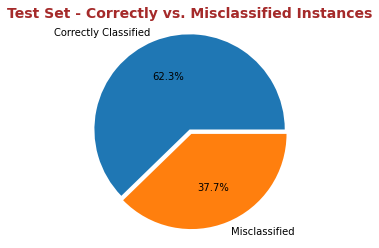

In [80]:
conf_matrix = np.array([[2144, 162, 137, 184],
                        [ 254, 1619, 317, 459],
                        [ 228, 333, 1339, 685],
                        [ 176, 407,  651, 1489]])

#Calculate total correctly classified instances
correctly_classified_total = np.sum(np.diag(conf_matrix))
print(f'Total Correctly Classified Instances on test set of model 2: {correctly_classified_total}')

#Calculate total misclassified instances
misclassified_total = np.sum(conf_matrix) - correctly_classified_total
print(f'Total Misclassified Instances on test set of model 2: {misclassified_total}')

#Plot pie chart for test set
plt.pie([correctly_classified_total, misclassified_total], labels=['Correctly Classified', 'Misclassified'], explode=(0.05, 0), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Test Set - Correctly vs. Misclassified Instances', fontdict={'fontsize': 14, 'fontweight': 'bold', 'color': 'brown'})
plt.show()

In [81]:
#Cross-validation scores with the best model
cv_scores_rf = cross_val_score(rf_best_model, X_train_scaled_2, y_train_2, scoring='f1_weighted', cv=StratifiedKFold(n_splits=5))
print('Cross-Validation Scores with  Best Model of Random Forest Classification:')
print(cv_scores_rf)
print(f'Average F1 Weighted Score: {cv_scores_rf.mean():.4f}')
print(f'Standard Deviation of F1 Weighted Scores: {cv_scores_rf.std():.4f}')

Cross-Validation Scores with  Best Model of Random Forest Classification:
[0.60023359 0.6046809  0.60461586 0.60901985 0.60678219]
Average F1 Weighted Score: 0.6051
Standard Deviation of F1 Weighted Scores: 0.0029


In [82]:
#Individual cross-validation scores
for i, score in enumerate(cv_scores_rf):
    print(f'Fold {i + 1}: {score:.4f}')

Fold 1: 0.6002
Fold 2: 0.6047
Fold 3: 0.6046
Fold 4: 0.6090
Fold 5: 0.6068


In [83]:
#Train the model on the entire training set
rf_best_model.fit(X_train_scaled_2, y_train_2)

RandomForestClassifier(n_estimators=200, random_state=42)

In [84]:
#Overfitting Analysis of Model 2
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('F1 Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')
    plt.legend(loc='best')
    return plt

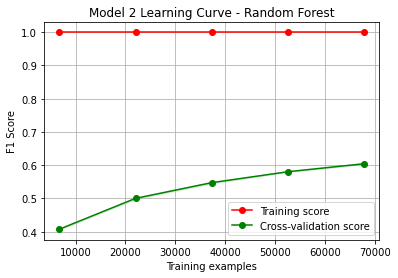

In [85]:
#Plot learning curves
plot_learning_curve(rf_best_model, 'Model 2 Learning Curve - Random Forest', X_train_scaled_2, y_train_2, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
plt.show()

## Optimal PSP prediction for each exiting transaction

In [86]:
#Extract 'PSP' column for comparison
psp_column = data2['PSP']

In [87]:
#Drop 'PSP' and 'success' columns from the features
X_predict = data2.drop(['PSP', 'success'], axis=1)

In [88]:
#Define numeric features and apply StandardScaler
numeric_features = ['amount', '3D_secured', 'fee', 'day_of_week', 'minute_of_day', 'payment_attempts', 'success_probabilities']
numeric_transformer = StandardScaler()

#Define categorical features and apply OneHotEncoder
categorical_features = ['country', 'card']
categorical_transformer = OneHotEncoder()

#Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [89]:
#Transform the features using the preprocessor
X_predict_transformed = preprocessor.fit_transform(X_predict)

In [90]:
#Predict the 'PSP' values using the best Random Forest model
data2['Predicted_PSP'] = rf_best_model.predict(X_predict_transformed)

In [91]:
#Restore the original 'PSP' values for comparison
data2['PSP'] = psp_column
data2

,country,amount,success,PSP,3D_secured,card,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,Predicted_PSP
9238,Austria,6,0,Moneycard,0,Diners,2.0,3,229,1,0.350,Goldcard
9239,Austria,6,0,Simplecard,0,Diners,0.5,3,229,2,0.355,UK_Card
22742,Austria,6,1,Simplecard,0,Master,1.0,6,841,1,0.350,Goldcard
33737,Austria,6,0,UK_Card,0,Diners,1.0,4,302,1,0.355,Goldcard
33738,Austria,6,0,UK_Card,0,Diners,1.0,4,302,2,0.345,Simplecard
...,...,...,...,...,...,...,...,...,...,...,...,...
2619,Switzerland,499,0,UK_Card,0,Master,1.0,3,247,1,0.450,Goldcard
2620,Switzerland,499,0,UK_Card,0,Master,1.0,3,247,2,0.410,Goldcard
2621,Switzerland,499,0,UK_Card,0,Master,1.0,3,248,1,0.450,Goldcard
2622,Switzerland,499,0,UK_Card,0,Master,1.0,3,248,2,0.410,Goldcard


In [92]:
#Handle ties and choose the most cost-effective PSP
def choose_best_psp(row):
    if pd.Series(row['Predicted_PSP']).nunique() == 1:
        return row['Predicted_PSP']
    else:
        min_fee_psp = row.loc[row['fee'].idxmin()]['Predicted_PSP']
        tied_rows = row[row['Predicted_PSP'].duplicated(keep=False)]
        if min_fee_psp in tied_rows['Predicted_PSP'].values:
            return min_fee_psp
        else:
            return tied_rows.loc[tied_rows['fee'].idxmin()]['Predicted_PSP']

When the predictive model identifies multiple Payment Service Providers (PSPs) as equally likely candidates for a transaction, the selection process then prioritizes cost-effectiveness. In such cases where there is a tie in the predictions, the system filters out these tied predictions to assess them separately. If the PSP with the overall lowest transaction fee is not among the tied candidates, the choice defaults to the PSP among the tied options that offers the lowest fee. This approach ensures that not only is the transaction likely to succeed, but it is also executed in the most cost-effective manner possible.

In [93]:
#Apply the function to each row in data2
data2['Best_PSP'] = data2.apply(choose_best_psp, axis=1)
data2.head()

,country,amount,success,PSP,3D_secured,card,fee,day_of_week,minute_of_day,payment_attempts,success_probabilities,Predicted_PSP,Best_PSP
9238,Austria,6,0,Moneycard,0,Diners,2.0,3,229,1,0.350,Goldcard,Goldcard
9239,Austria,6,0,Simplecard,0,Diners,0.5,3,229,2,0.355,UK_Card,UK_Card
22742,Austria,6,1,Simplecard,0,Master,1.0,6,841,1,0.350,Goldcard,Goldcard
33737,Austria,6,0,UK_Card,0,Diners,1.0,4,302,1,0.355,Goldcard,Goldcard
33738,Austria,6,0,UK_Card,0,Diners,1.0,4,302,2,0.345,Simplecard,Simplecard


In [94]:
#Count occurrences of Predicted_PSP
predicted_psp_counts = data2['Predicted_PSP'].value_counts()

#Count occurrences of Best_PSP
best_psp_counts = data2['Best_PSP'].value_counts()

#Combine the counts into a DataFrame
matching_counts = pd.DataFrame({
    'Predicted_PSP_Count': predicted_psp_counts,
    'Best_PSP_Count': best_psp_counts
})
print(matching_counts)

            Predicted_PSP_Count  Best_PSP_Count
Goldcard                  39366           39366
UK_Card                    4132            4132
Moneycard                  3658            3658
Simplecard                 3254            3254
